# Surface Mapping using Apriltags

In this notebook, we show how to use AprilTags to map from gaze-to screen coordinates. Along the way, we will also show some additional epoching functionalities.

To do so, we have collected a dataset where a participant freely views artworks presented on screen. Each artwork is shown for 4s, followed by a 0.5s inter trial intervall and a 0.5s central fixation cross. We can download this dataset using `get_sample_data()`.

In [1]:
import numpy as np

from pyneon import Recording, get_sample_data

# Load a sample recording
rec_dir = (
    get_sample_data("Artworks") / "Timeseries Data + Scene Video" / "artworks-9a141750"
)
print("Loading sample recording from:", rec_dir)
rec = Recording(rec_dir)
print(rec)

Loading sample recording from: C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\data\Artworks\Timeseries Data + Scene Video\artworks-9a141750

Recording ID: 9a141750-95ca-48ee-9693-53bbb896b87e
Wearer ID: c4f68887-e96c-467f-a901-0fc9fce09c0a
Wearer name: JGH
Recording start time: 2025-06-16 12:49:27.817000
Recording duration: 357.538s
                 exist                  filename                                                                                                                                        path
3d_eye_states     True         3d_eye_states.csv         C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\data\Artworks\Timeseries Data + Scene Video\artworks-9a141750\3d_eye_states.csv
blinks            True                blinks.csv                C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\data\Artworks\Timeseries Data + Scene Video\artworks-9a141750\blinks.csv
events            True                events.csv                C:\Users\jan-gabriel.hartel\D

Let us take a closer look at the events file, populated with triggers sent during the initial viewing

In [2]:
event_data = rec.events.data
print(event_data.head(10))

                                                                  name  \
timestamp [ns]                                                           
1750070967817000000                                    recording.begin   
1750070973028401000                                     fixation onset   
1750070973726906000   image onset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8   
1750070977877138000  image offset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8   
1750070978659847000                                     fixation onset   
1750070979391162000   image onset 29a102da-4838-432b-7373-a3c7f5679d75   
1750070983510925000  image offset 29a102da-4838-432b-7373-a3c7f5679d75   
1750070984367660000                                     fixation onset   
1750070985019038000   image onset 9c15b0f6-c5d3-ffa3-a853-0a62a4520400   
1750070989241548000  image offset 9c15b0f6-c5d3-ffa3-a853-0a62a4520400   

                          type  
timestamp [ns]                  
1750070967817000000  recording  
175007097302

We can see that the name column holds the information ofinterest to us. As the column ontains both information about the event_type as well as its name, we will first parse these apart. This process is a bit lengthy, but necessary to make sense of our data

In [3]:
# parse the name column, look for the key words image onset and image offset
def parse_event_name(name):
    if "image onset" in name.lower():
        type = "image onset"
        name = name.lower().replace("image onset ", "").strip()
    elif "image offset" in name.lower():
        type = "image offset"
        name = name.lower().replace("image offset ", "").strip()
    else:
        type = "other"
        name = None
    return type, name


for i, row in event_data.iterrows():
    type, name = parse_event_name(row["name"])
    event_data.at[i, "event_type"] = type
    event_data.at[i, "image_name"] = name

print(event_data.head(5))

                                                                  name  \
timestamp [ns]                                                           
1750070967817000000                                    recording.begin   
1750070973028401000                                     fixation onset   
1750070973726906000   image onset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8   
1750070977877138000  image offset 8c63372e-dfd6-ab25-cfc8-a6569f25f0c8   
1750070978659847000                                     fixation onset   

                          type    event_type  \
timestamp [ns]                                 
1750070967817000000  recording         other   
1750070973028401000  recording         other   
1750070973726906000  recording   image onset   
1750070977877138000  recording  image offset   
1750070978659847000  recording         other   

                                               image_name  
timestamp [ns]                                             
1750070967817000000     

Resetting video...
Resetting video...
Resetting video...


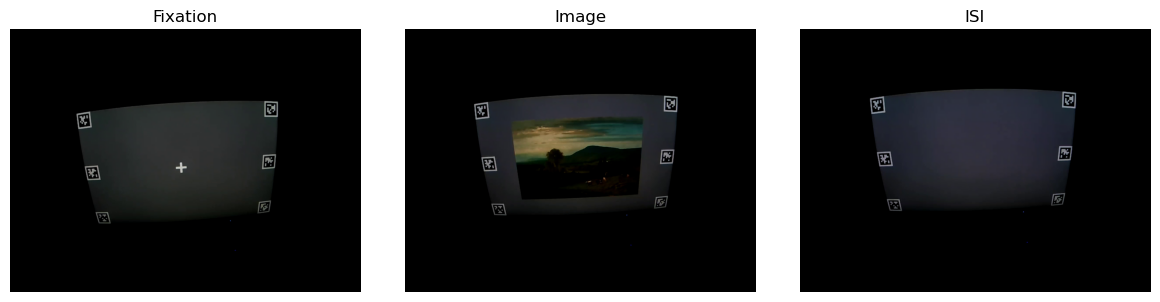

In [4]:
import matplotlib.pyplot as plt

video = rec.video

fig, axs = plt.subplots(1, 3, figsize=(12, 3))
video.plot_frame(170, ax=axs[0], auto_title=False, show=False)
video.plot_frame(200, ax=axs[1], auto_title=False, show=False)
video.plot_frame(320, ax=axs[2], auto_title=False, show=False)
axs[0].set_title("Fixation")
axs[1].set_title("Image")
axs[2].set_title("ISI")
plt.tight_layout()
plt.show()

In all of the frames shown above, we can see QR-code like markers at the borders of the screen. These are called apriltags and can be used as fiducial markers to relate video to real-world coordinates. PyNeon wraps a function that performs the detection of these. For computational efficiency, we only perform one detection every 30 frames.

In [5]:
all_detections = rec.detect_apriltags(skip_frames=30)
print(all_detections.data.head())

Detecting AprilTags (random access): 100%|██████████| 357/357 [00:13<00:00, 26.76it/s]

                     processed_frame_idx  frame_idx  tag_id  \
timestamp [ns]                                                
1750070971664700000                    3         90       0   
1750070971664700000                    3         90       1   
1750070971664700000                    3         90       2   
1750070971664700000                    3         90       3   
1750070971664700000                    3         90       4   

                                                               corners  \
timestamp [ns]                                                           
1750070971664700000  [[275.7712707519531, 479.94992065429693], [327...   
1750070971664700000  [[322.27392578125006, 724.976806640625], [372....   
1750070971664700000  [[380.61767578125006, 928.1921386718751], [427...   
1750070971664700000  [[1137.983520507812, 410.68994140624994], [118...   
1750070971664700000  [[1130.1645507812498, 646.8099975585936], [117...   

                                       

Having detected the apriltags, we now need to provide information on the real-world coordinates of our apriltags. This is solved via a tag_info dataframe, which we generate below.

In [6]:
import pandas as pd


def generate_tag_info(win_size, tag_ids=None, tag_size=200):
    """
    Generate marker information for a given window size.

    Args:
        win_size (tuple): The width and height of the window.
        tag_ids (list, optional): List of tag IDs. Defaults to [0, 1, 2, 3, 4, 5].
        tag_size (int, optional): Size of the tags. Defaults to 200.

    Returns:
        pd.DataFrame: A DataFrame containing marker IDs and their corner positions.
    """
    if tag_ids is None:
        tag_ids = [0, 1, 2, 3, 4, 5]  # Default tag IDs

    win_half_width, win_half_height = np.array(win_size) / 2
    half_tag_size = tag_size / 2

    positions = [
        (-win_half_width + half_tag_size, win_half_height - half_tag_size),  # top-left
        (-win_half_width + half_tag_size, 0),  # middle-left
        (
            -win_half_width + half_tag_size,
            -win_half_height + half_tag_size,
        ),  # bottom-left
        (win_half_width - half_tag_size, win_half_height - half_tag_size),  # top-right
        (win_half_width - half_tag_size, 0),  # middle-right
        (
            win_half_width - half_tag_size,
            -win_half_height + half_tag_size,
        ),  # bottom-right
    ]

    marker_corners = []
    for pos in positions:
        cx, cy = pos
        corners = [
            [cx - half_tag_size, cy + half_tag_size],  # top-left
            [cx + half_tag_size, cy + half_tag_size],  # top-right
            [cx + half_tag_size, cy - half_tag_size],  # bottom-right
            [cx - half_tag_size, cy - half_tag_size],  # bottom-left
        ]
        marker_corners.append(corners)

    tag_info = pd.DataFrame({"marker_id": tag_ids, "marker_corners": marker_corners})

    return tag_info


tag_info = generate_tag_info((1920, 1080))

In [15]:
print(tag_info)

   marker_id                                     marker_corners
0          0  [[-960.0, 540.0], [-760.0, 540.0], [-760.0, 34...
1          1  [[-960.0, 100.0], [-760.0, 100.0], [-760.0, -1...
2          2  [[-960.0, -340.0], [-760.0, -340.0], [-760.0, ...
3          3  [[760.0, 540.0], [960.0, 540.0], [960.0, 340.0...
4          4  [[760.0, 100.0], [960.0, 100.0], [960.0, -100....
5          5  [[760.0, -340.0], [960.0, -340.0], [960.0, -54...


With this, we can now run the ``find_homograpghy()`` method. This method finds the map between the detections and the provided coordinates for each frame. As we did not do detections in every frame, we further provide the skip_frames as used before so that the homographies can be interpolated.

In [7]:
homographies = rec.find_homographies(
    tag_info=tag_info, all_detections=all_detections, skip_frames=30
)

Interpolating homographies: 100%|██████████| 352/352 [00:00<00:00, 15188.47it/s]


with this, we can finally transform both gaze and fixation coordinates into the screen's reference frame:

In [8]:
synced_gaze = rec.sync_gaze_to_video()
gaze_on_screen = rec.gaze_on_surface(homographies=homographies, synced_gaze=synced_gaze)
fixations_on_screen = rec.fixations_on_surface(gaze_on_surface=gaze_on_screen)

Applying homography to gaze points: 100%|██████████| 10695/10695 [00:06<00:00, 1596.87it/s]


Besides the step-by-step process we have shown here, calling ``gaze_on_screen`` or ``fixations_on_screen``, computes derivatives with default values.

In [9]:
gaze_on_screen = rec.gaze_on_surface(tag_info=tag_info, overwrite=False)
fixations_on_screen = rec.fixations_on_surface(gaze_on_surface=gaze_on_screen)

Conveniently, on screen fixation data can be epoched just as well as any other type of data.

In [10]:
from pyneon import Epochs, events_to_times_df

event_times = events_to_times_df(
    rec.events, t_before=1, t_after=4.5, event_name="fixation onset"
)

gaze_on_screen_epochs = Epochs(gaze_on_screen, event_times)
fixation_on_screen_epochs = Epochs(fixations_on_screen, event_times)
eye_states_epochs = Epochs(rec.eye_states, event_times)
gaze_epochs = Epochs(rec.gaze, event_times)
saccades_epochs = Epochs(rec.saccades, event_times)
blinks_epochs = Epochs(rec.blinks, event_times)

C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 0.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 1.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 2.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 3.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning: No data found for epoch 36.
  warnings.warn(f"No data found for epoch {i}.", RuntimeWarning)
C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\pyneon\epochs.py:445: RuntimeWarning:

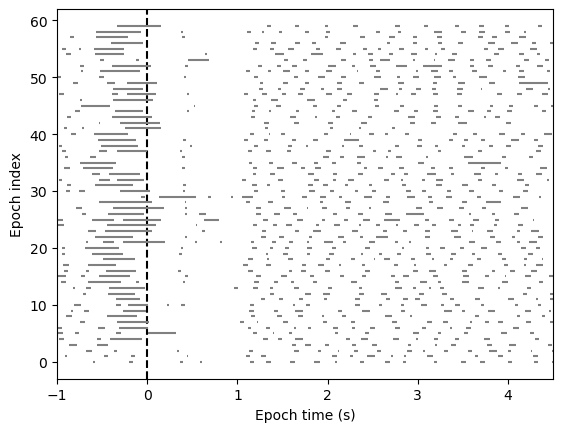

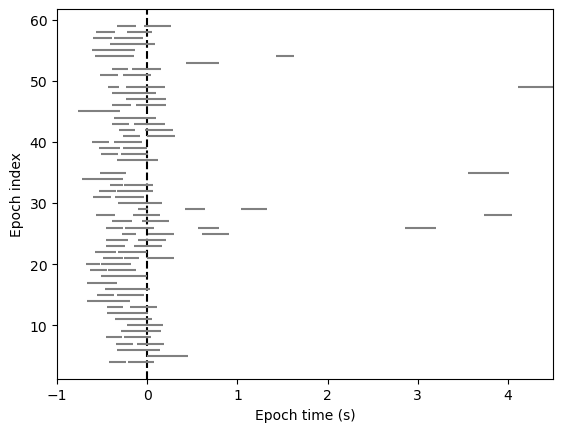

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Epoch time (s)', ylabel='Epoch index'>)

In [11]:
saccades_epochs.plot()
blinks_epochs.plot()

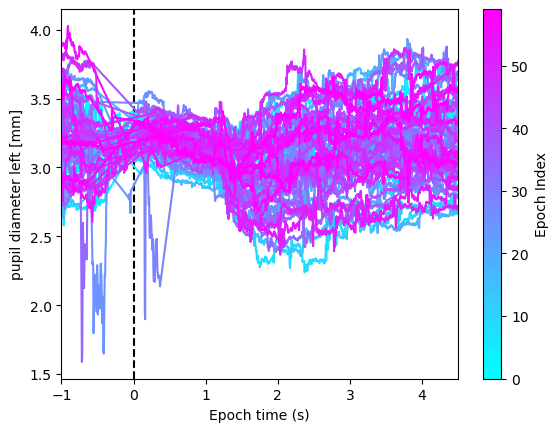

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Epoch time (s)', ylabel='pupil diameter left [mm]'>)

In [ ]:
eye_states_interpolated = rec.eye_states.interpolate_events(rec.blinks)
eye_states_epochs = Epochs(eye_states_interpolated, event_times)
eye_states_epochs.plot(column_name="pupil diameter left [mm]")

To plot anything more meaningful, we need to actually manually manipulate data

In [13]:
epochs = fixation_on_screen_epochs.epochs
data = epochs.data
data[0].columns

Index(['fixation id', 'end timestamp [ns]', 'duration [ms]', 'fixation x [px]',
       'fixation y [px]', 'azimuth [deg]', 'elevation [deg]',
       'gaze x [surface coord]', 'gaze y [surface coord]', 'epoch time'],
      dtype='object')

C:\Users\jan-gabriel.hartel\AppData\Local\Temp\ipykernel_28488\3893021640.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


(-600.0, 600.0)

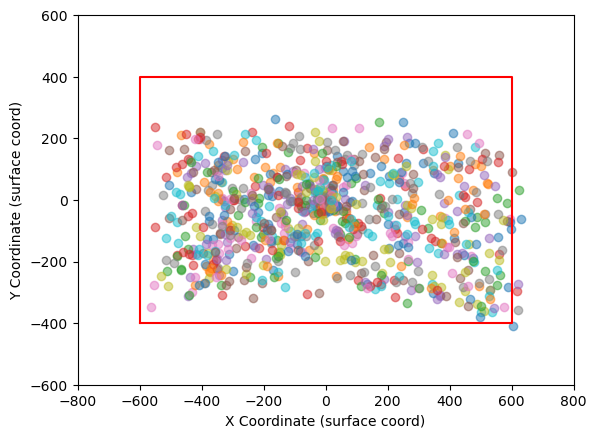

In [ ]:
for i, epoch in fixation_on_screen_epochs.epochs.iterrows():
    data = epoch["data"]

    # show x and y coordinates of all fixations as scatter plot
    plt.scatter(
        data["gaze x [surface coord]"],
        data["gaze y [surface coord]"],
        label=f"Epoch {i}",
        alpha=0.5,
    )

# add the image outline to the polt (image has size of 1200x800, centered at 0, 0)
plt.plot(
    [-600, 600, 600, -600, -600],
    [-400, -400, 400, 400, -400],
    color="red",
    label="Image outline",
)

plt.xlabel("X Coordinate (surface coord)")
plt.ylabel("Y Coordinate (surface coord)")

plt.xlim(-800, 800)
plt.ylim(-600, 600)